## Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.ensemble._forest import RandomForestRegressor
from sklearn import tree
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

## Data Reading

In [63]:
data = pd.read_csv('https://query.data.world/s/7do5jwejce7drzdqorrzhpjtn6hrb3?dws=00000' ,encoding='latin1')

In [5]:
data.head()

,ssl,address,owner,neighborhood,sub_neighborhood,use_code,2014_assessment
0,0150 0295,1727 SEATON ST NW,MARTIN RAVALLION,OLD CITY II,D,23,"$633,320.00"
1,0150 0296,1724 V ST NW,KEITH R STEMPLE,OLD CITY II,D,11,"$755,120.00"
2,0150 0297,1722 V ST NW,HEATHER M PETRUZZI,OLD CITY II,D,11,"$721,760.00"
3,0150 0298,1720 V ST NW,MICHAEL MOSIER,OLD CITY II,D,11,"$846,330.00"
4,0150 0299,1718 V ST NW,WILLIAM M BREWSTER,OLD CITY II,D,11,"$682,550.00"


### Data Manipulation

In [6]:
# Function that deletes the first element of the data in the column (we will use it when reading data)

def remove_from_beginning(x):
            return x[1:]

In [64]:
# Removing the $ sign in the 2014_assessment column

data["2014_assessment"] = data["2014_assessment"].map(remove_from_beginning)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199059 entries, 0 to 199058
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   ssl               199059 non-null  object
 1   address           199058 non-null  object
 2   owner             199040 non-null  object
 3   neighborhood      199059 non-null  object
 4   sub_neighborhood  154110 non-null  object
 5   use_code          199059 non-null  int64 
 6   2014_assessment   199059 non-null  object
dtypes: int64(1), object(6)
memory usage: 10.6+ MB


In [65]:
# Removing the dots and commas in the currency in the 2014 assessment column

data["2014_assessment"] = data["2014_assessment"].str.replace(',','')
data["2014_assessment"] = data["2014_assessment"].str.replace('.','')

In [66]:
data["2014_assessment"].value_counts().head(15)

3500000         2322
2500000         1471
3000000         1221
1000000         1034
2000000          927
1500000          800
4000000          740
ot Available     330
2700000          290
100000           274
5000000          254
1700000          232
2300000          209
1800000          174
26050000         149
Name: 2014_assessment, dtype: int64

In [12]:
# Dropping rows containing 'ot Available'

data = data[ ~ (data["2014_assessment"] == 'ot Available') ]

In [13]:
# Converting currency data to numeric value

data["2014_assessment"] = data["2014_assessment"].astype(int)

In [14]:
data["2014_assessment"].describe()

count    1.987290e+05
mean     1.260293e+08
std      1.350104e+09
min      1.000000e+03
25%      2.037400e+07
50%      3.442800e+07
75%      6.047100e+07
max      9.999828e+10
Name: 2014_assessment, dtype: float64

### Converting use_code column to string type

In [15]:
# Although use_code appears as an integer, it actually represents a categorical variable

data["use_code"] = data["use_code"].astype(str)

### Checking duplicates

In [16]:
data.duplicated().sum()

0

### Dropping unnecessary columns

In [17]:
data = data.drop( columns= ['address', 'owner', "ssl"])

### Missing values treatment for sub_neighborhood column

In [18]:
data.dropna(subset=['sub_neighborhood'], inplace=True)

In [19]:
data.isnull().sum()

neighborhood        0
sub_neighborhood    0
use_code            0
2014_assessment     0
dtype: int64

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153810 entries, 0 to 199058
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   neighborhood      153810 non-null  object
 1   sub_neighborhood  153810 non-null  object
 2   use_code          153810 non-null  object
 3   2014_assessment   153810 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.9+ MB


## Modelling

In [21]:
X = data.drop('2014_assessment', axis=1)  
y = data["2014_assessment"]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3,
random_state = 0)

In [22]:
Xtrain.shape

(107667, 3)

### One hot encoder

In [23]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

column_trans = make_column_transformer((OneHotEncoder(handle_unknown="ignore", sparse=False), Xtrain.columns ), 
                                       remainder='passthrough')

In [25]:
Xtrain= column_trans.fit_transform(Xtrain)
Xtest = column_trans.transform(Xtest)

In [26]:
column_trans.get_feature_names_out()


array(['onehotencoder__neighborhood_16TH ST. HEIGHTS',
       'onehotencoder__neighborhood_AMERICAN UNIV. PARK',
       'onehotencoder__neighborhood_ANACOSTIA',
       'onehotencoder__neighborhood_BERKLEY',
       'onehotencoder__neighborhood_BOLLING AFB & NAVAL RES',
       'onehotencoder__neighborhood_BRENTWOOD',
       'onehotencoder__neighborhood_BRIGHTWOOD',
       'onehotencoder__neighborhood_BROOKLAND',
       'onehotencoder__neighborhood_BURLEITH',
       'onehotencoder__neighborhood_CAPITOL HILL',
       'onehotencoder__neighborhood_CENTRAL',
       'onehotencoder__neighborhood_CHEVY CHASE',
       'onehotencoder__neighborhood_CHILLUM',
       'onehotencoder__neighborhood_COLUMBIA HEIGHTS',
       'onehotencoder__neighborhood_CONGRESS HEIGHTS',
       'onehotencoder__neighborhood_D.C. VILLAGE',
       'onehotencoder__neighborhood_DEANWOOD',
       'onehotencoder__neighborhood_ECKINGTON',
       'onehotencoder__neighborhood_FOGGY BOTTOM',
       'onehotencoder__neighborhood_FOR

In [60]:
Xtrain.shape

(107667, 155)

In [27]:
Xtrain

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
Xtest

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
Xtrain.shape

(107667, 155)

### RandomForestRegressor

In [109]:
rfr = RandomForestRegressor(n_estimators = 100)
# Train the model using the training sets
rfr = rfr.fit(Xtrain, ytrain)
# Make predictions using the testing set
ypred = rfr.predict(Xtest)

In [110]:
# The mean absolute error
print("MAE = %5.3f" % mean_absolute_error(ytest, ypred))
# Explained variance score: 1 is perfect prediction
print("R^2 = %0.5f" % r2_score(ytest, ypred))
# The mean squared error
print("MSE = %5.3f" % mean_squared_error(ytest, ypred))

MAE = 48939542.071
R^2 = 0.36956
MSE = 606997416571639552.000


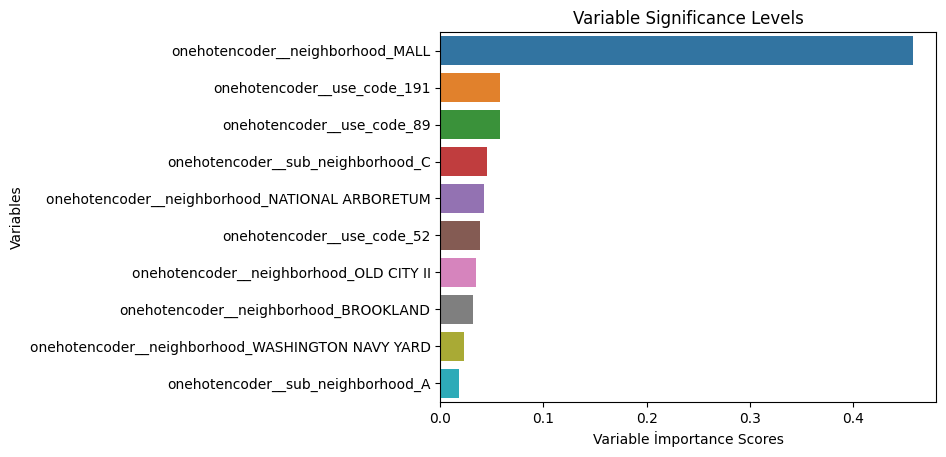

In [111]:
feature_imp = pd.Series(rfr.feature_importances_,
                        index=column_trans.get_feature_names_out()
).sort_values(ascending=False)

sns.barplot(x=feature_imp.head(10), y=feature_imp.index[:10])
plt.xlabel('Variable İmportance Scores')
plt.ylabel('Variables')
plt.title("Variable Significance Levels")
plt.show()

### DecisionTree Regression

In [112]:
dtr = tree.DecisionTreeRegressor()
# Train the model using the training sets
dtr = dtr.fit(Xtrain, ytrain)
# Make predictions using the testing set
y_pred=dtr.predict(Xtest)

In [113]:
# The mean absolute error
print("MAE = %5.3f" % mean_absolute_error(ytest, y_pred))
# Explained variance score: 1 is perfect prediction
print("R^2 = %0.5f" % r2_score(ytest, y_pred))
# The mean squared error
print("MSE = %5.3f" % mean_squared_error(ytest, y_pred))

MAE = 48689305.227
R^2 = 0.38933
MSE = 587969698899040640.000


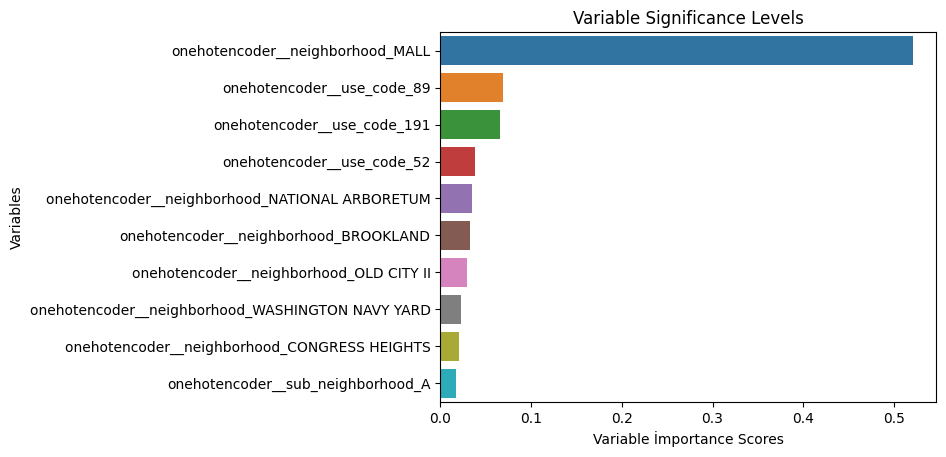

In [114]:
feature_imp = pd.Series(dtr.feature_importances_,
                        index=column_trans.get_feature_names_out()
).sort_values(ascending=False)

sns.barplot(x=feature_imp.head(10), y=feature_imp.index[:10])
plt.xlabel('Variable İmportance Scores')
plt.ylabel('Variables')
plt.title("Variable Significance Levels")
plt.show()

### XGboost Regression (BEST)

In [44]:
xgb = XGBRegressor()
# Train the model using the training sets
xgb = xgb.fit(Xtrain, ytrain)
# Make predictions using the testing set
y_pred=xgb.predict(Xtest)

In [45]:
# The mean absolute error
print("MAE = %5.3f" % mean_absolute_error(ytest, y_pred))
# Explained variance score: 1 is perfect prediction
print("R^2 = %0.5f" % r2_score(ytest, y_pred))
# The mean squared error
print("MSE = %5.3f" % mean_squared_error(ytest, y_pred))

MAE = 51111372.323
R^2 = 0.41685
MSE = 561464734823711616.000


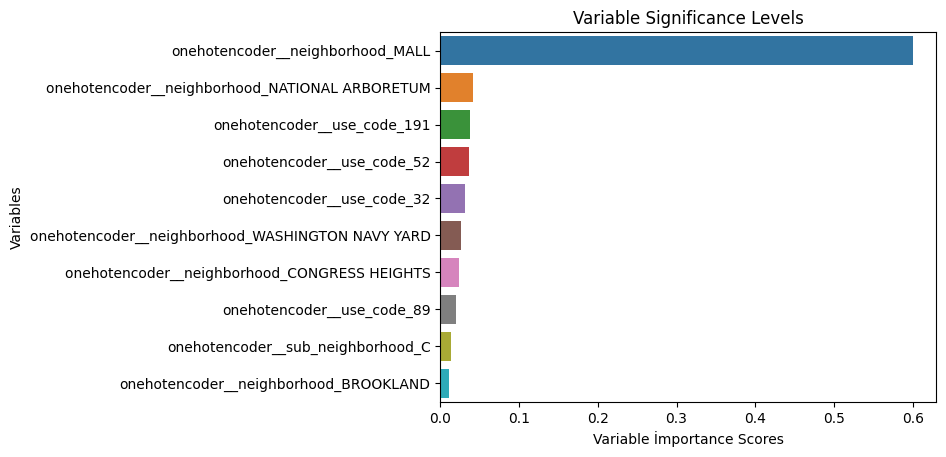

<Figure size 640x480 with 0 Axes>

In [42]:
feature_imp = pd.Series(xgb.feature_importances_,
                        index=column_trans.get_feature_names_out()
).sort_values(ascending=False)

sns.barplot(x=feature_imp.head(10), y=feature_imp.index[:10])
plt.xlabel('Variable İmportance Scores')
plt.ylabel('Variables')
plt.title("Variable Significance Levels")
plt.show()
plt.savefig('Variable_Significance_Levels.png')

### Model Tunning with XGboost Regression

In [150]:
xgb_params = {
        'n_estimators': [10, 50],
        'subsample': [1, 1.2],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1,0.01],
        }
xgb = XGBRegressor()

xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 10, n_jobs = -1, verbose = 2)
xgb_cv_model.fit(Xtrain, ytrain)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 4, 5],
                         'n_estimators': [10, 50], 'subsample': [1, 1.2]},
             verbose=2)

In [151]:
xgb_cv_model.best_params_


{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 10, 'subsample': 1}

In [152]:
xgb = XGBRegressor(learning_rate = 0.1, 
                    max_depth = 4,
                    n_estimators = 10,
                    subsample = 1)
xgb_tuned =  xgb.fit(Xtrain,ytrain)
y_pred = xgb_tuned.predict(Xtest)

In [153]:
# The mean absolute error
print("MAE = %5.3f" % mean_absolute_error(ytest, y_pred))
# Explained variance score: 1 is perfect prediction
print("R^2 = %0.5f" % r2_score(ytest, y_pred))
# The mean squared error
print("MSE = %5.3f" % mean_squared_error(ytest, y_pred))

MAE = 60409220.535
R^2 = 0.32498
MSE = 649921524097735936.000


### Saving Best Model (XGBoost without tunning)

In [47]:
# Save Model
import joblib
joblib.dump(xgb, "model.pkl")

# Read models
regr_loaded = joblib.load("model.pkl")